In [1]:
# This notebook runs on Colab
!pip install transformers datasets sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Preprocessing

In [2]:
# Access data files on Colab
from google.colab import files
uploaded = files.upload()

Saving poemonly_subsentence_translate_md_an.json to poemonly_subsentence_translate_md_an (1).json


In [3]:
import json

f = open('poemonly_subsentence_translate_md_an.json')
data = json.load(f)

In [4]:
from datasets import load_dataset
pos_dataset = load_dataset('json', data_files = 'poemonly_subsentence_translate_md_an.json')
pos_dataset

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 11542
    })
})

In [5]:
from sklearn.model_selection import train_test_split
pos_dataset_split = pos_dataset['train'].train_test_split(test_size = 0.2, seed=1234)

In [6]:
data = pos_dataset["train"]
# for testing, use small
# small = pos_dataset["train"].shuffle(seed=42).select(range(1_000))

In [7]:
split = data.train_test_split(seed=42)
#split = small.train_test_split(seed=42)

In [8]:
split["train"][0]

{'id': 1286, 'translation': {'ancient': '莫见长安行乐处', 'modern': '请不要以为长安是行乐所在'}}

In [9]:
split['train'][1]

{'id': 8778, 'translation': {'ancient': '寥落烟中一雁寒', 'modern': '大概只能空对那横空的孤雁了'}}

## Tokenization

In [10]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

checkpoint = "uer/bart-chinese-6-960-cluecorpussmall"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


In [11]:
modern = split['train'][5]['translation']['modern']
ancient = split['train'][5]['translation']['ancient']
modern, ancient

('定会万古留名传谥', '千古传名谥')

In [12]:
inputs = tokenizer(modern)
targets = tokenizer(ancient)
print(inputs)
print(ancient)

{'input_ids': [101, 2137, 833, 674, 1367, 4522, 1399, 837, 6471, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
千古传名谥


In [13]:
tokenizer.convert_ids_to_tokens(inputs['input_ids']), tokenizer.convert_ids_to_tokens(targets['input_ids'])

(['[CLS]', '定', '会', '万', '古', '留', '名', '传', '谥', '[SEP]'],
 ['[CLS]', '千', '古', '传', '名', '谥', '[SEP]'])

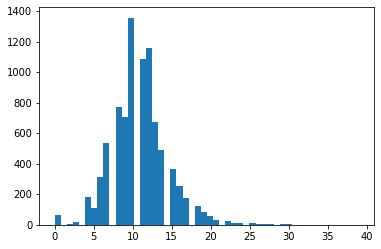

In [14]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['modern']) for tr in train]

plt.hist(input_lens, bins=50); # in order to see the maximum length for truncation

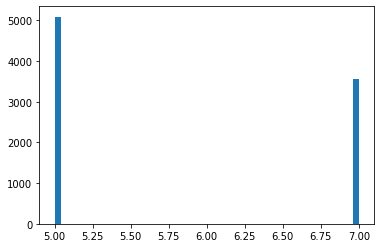

In [15]:
target_lens = [len(tr['ancient']) for tr in train]
plt.hist(target_lens, bins=50);

In [16]:
max_input_len = 64
max_target_len = 32

def tokenizer_fn(batch):
  inputs = [x['modern'] for x in batch['translation']]
  targets = [x['ancient'] for x in batch['translation']]

  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)

  tokenized_targets = tokenizer(
    targets, max_length=max_target_len, truncation=True)
  
  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [17]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8656
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2886
    })
})

## Metric and Model Settings

In [19]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [20]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [21]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys() 
# deta_collator needs the inputs to be a list of dict, each dict contains the info of a sample. so if we directly pass 
# tokenized_datasets["train"][1:3], as the previous 2 blocks shows, it won't fit the format.

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [22]:
!pip install bert-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from datasets import load_metric

bert_metric = load_metric("bertscore")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# test metric compute
bert_metric.compute(
    predictions=["常恐零露降"], references=[["常常担心寒冷的露珠降临"]], lang='zh') # need to specify language for bert score

{'precision': [0.6533329486846924],
 'recall': [0.6154574751853943],
 'f1': [0.6338298916816711],
 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.11(hug_trans=4.22.2)'}

In [25]:
import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels
  print(preds)

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='zh')

  return {'bert_score': np.mean(bert_score['f1'])}

In [26]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "finetuned-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  fp16=True,
)

In [27]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using cuda_amp half precision backend


## Train and Evaluation

In [28]:
# check metrics before start training
trainer.evaluate(max_length=max_target_len)

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2886
  Batch size = 64


[[ 101  791 1921 ...  102  102    0]
 [ 101 5774 7356 ...  102  102    0]
 [ 101 1762  974 ...  102  102    0]
 ...
 [ 101 7599 1327 ...  102  102    0]
 [ 101 2687 4351 ...  102  102    0]
 [ 101  697 2151 ...  102  102    0]]


{'eval_loss': 11.795215606689453,
 'eval_bert_score': 0.6527524456867144,
 'eval_runtime': 32.9485,
 'eval_samples_per_second': 87.591,
 'eval_steps_per_second': 1.396}

In [29]:
# may run out of gpu memory - try to restart runtime
# or get a more powerful gpu!
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8656
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 813


Step,Training Loss
500,4.161700


Saving model checkpoint to finetuned-model/checkpoint-271
Configuration saved in finetuned-model/checkpoint-271/config.json
Model weights saved in finetuned-model/checkpoint-271/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-271/tokenizer_config.json
Special tokens file saved in finetuned-model/checkpoint-271/special_tokens_map.json
Deleting older checkpoint [finetuned-model/checkpoint-542] due to args.save_total_limit
Saving model checkpoint to finetuned-model/checkpoint-542
Configuration saved in finetuned-model/checkpoint-542/config.json
Model weights saved in finetuned-model/checkpoint-542/pytorch_model.bin
tokenizer config file saved in finetuned-model/checkpoint-542/tokenizer_config.json
Special tokens file saved in finetuned-model/checkpoint-542/special_tokens_map.json
Deleting older checkpoint [finetuned-model/checkpoint-813] due to args.save_total_limit
Saving model checkpoint to finetuned-model/checkpoint-813
Configuration saved in finetuned-model

TrainOutput(global_step=813, training_loss=3.899379978907211, metrics={'train_runtime': 160.0598, 'train_samples_per_second': 162.239, 'train_steps_per_second': 5.079, 'total_flos': 607754728488960.0, 'train_loss': 3.899379978907211, 'epoch': 3.0})

In [30]:
# check the metrics after training
trainer.evaluate(max_length=max_target_len)

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2886
  Batch size = 64


[[ 101  101  791 ...  102  102    0]
 [ 101  101 5774 ...  102  102    0]
 [ 101  101 6804 ...  102  102    0]
 ...
 [ 101  101 7599 ...  102  102    0]
 [ 101  101 2687 ...  102  102    0]
 [ 101  101  697 ...  102  102    0]]


{'eval_loss': 3.1971187591552734,
 'eval_bert_score': 0.7033041616074344,
 'eval_runtime': 20.8056,
 'eval_samples_per_second': 138.713,
 'eval_steps_per_second': 2.211,
 'epoch': 3.0}

## Save, load and use model

In [31]:
trainer.save_model("Chinese_Poem_Translation_BartBased")

Saving model checkpoint to Chinese_Poem_Translation_BartBased
Configuration saved in Chinese_Poem_Translation_BartBased/config.json
Model weights saved in Chinese_Poem_Translation_BartBased/pytorch_model.bin
tokenizer config file saved in Chinese_Poem_Translation_BartBased/tokenizer_config.json
Special tokens file saved in Chinese_Poem_Translation_BartBased/special_tokens_map.json


In [32]:
from transformers import pipeline
translator = pipeline("translation", model='Chinese_Poem_Translation_BartBased', device=0)

loading configuration file Chinese_Poem_Translation_BartBased/config.json
Model config BartConfig {
  "_name_or_path": "Chinese_Poem_Translation_BartBased",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 960,
  "decoder_attention_heads": 15,
  "decoder_ffn_dim": 3840,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 6,
  "decoder_start_token_id": 101,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 15,
  "encoder_ffn_dim": 3840,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  

In [51]:
input_setences = ["我借此火得度一生的茫茫黑夜",\
                  "千年后如若我再生于祖国的河岸",\
                  "千年后我再次拥有中国的稻田和周天子的雪山",\
                  "泥土中涌上的处处是夜之幻影",\
                  "在低压的暗云下唱着单调的东流的水",\
                  "它必须完成生命的长梦而非游戏中黄粱一梦",\
                  "你的身体每时每刻都触摸着宇宙",\
                  "那鸿雁要什么时候才能到",\
                  "春天江上的潮水仿佛连接着海面",\
                  "我的忧愁仿佛一江春天的潮水滚滚向东流去",\
                  "我也愿将自己埋葬在四周高高的山上"]

for s in input_setences:
    print(translator(s)[0]['translation_text'])

Your input_length: 22 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


借 此 火 得 一 生 夜
千 年 若 我 生 河 岸
千 年 周 天 子 雪 山
泥 土 处 处 夜 幻 影


Your input_length: 21 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


暗 云 唱 东 流 水
必 成 黄 粱 梦
身 体 每 时 触 宇 宙
鸿 雁 何 时 到


Your input_length: 21 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


江 潮 连 海 面
愁 似 一 江 春 东 流 去
愿 将 自 己 埋 四 高
